In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [15]:
# Units
nM = 1

min = 1

In [16]:
# Parameters

#PVAR
alpha_T  = 7.2e-3
alpha_C = 6.467e-6
KG = 57.1585
hON_min = 2.0202e-7
hON_max = 2.0020e-5
KL = 1.9851e3
nL = 1.3548
nG = 1.5557
hC = 1.5388
gamma_mol2fluo = 0.2549
L0 = 196.3930

# alpha_T  = 1e-3
# alpha_C = 0.0035
# KG = 8
# hON_min = 2.5e-7
# hON_max = 1e-6 * 100
# KL = 80
# nL = 3
# nG = 4
# hC = 1.200
# gamma_mol2fluo = 0.1000
# L0 = 180

# alpha_T  = 0.0354
# alpha_C = 1.38e-5
# KG = 174.0215
# hON_min = 3.9848e-8
# hON_max = 8.1092e-7
# KL = 959.9107
# nL = 1.3115
# nG = 2.5157
# hC = 1.200
# gamma_mol2fluo = 0.1000
# L0 = 180

#PFIX
Np = 10
KD = 1300
KC = 0.3333
kappa = 90
nr = 12221
nT = 597
nC = 219
g0 = 0.0987
PhiR_max = 0.5470
PhiR0 = 0.0660
rho_cell = 2e9
nu = 0.1921
AE = 10.5e3

In [17]:
# ODEs

def odefun(t,x,lambda_c, L):
    Tt, Td, C, phi_p = x
    Tt = np.max([Tt, 0])
    Td = np.max([Td, 0])
    C = np.max([C, 0])
    phi_p = np.max([phi_p, 0])

    # Algebraic variables
    PhiS = (nT * Tt + nC * C) / rho_cell
    lambda_p = (PhiR_max - PhiR0 - PhiS) * (nu * g0) / (g0 + nu * (1 + (AE/KD)/(1+((C/(kappa * KC)) ** hC))))

    # print(lambda_p)

    # Useful functions
    hON = hON_min + (hON_max - hON_min) * (L ** nL) / (L ** nL + KL ** nL)
    gON = Np * Td ** nG / (Td ** nG + KG ** nG)

    # Unbound ribosomes
    r_u = rho_cell * lambda_p / (nr*g0)

    # print(hON)

    ddt = np.zeros(4)
    # ddt[0] = alpha_T * lambda_p ** 2 / nu - lambda_p * Tt # dTt/dt
    # ddt[1] = hON * (Tt - 2 * (Td + gON)) ** 2 - lambda_p * (Td+gON) # dTd/dt
    # ddt[2] = alpha_C * (lambda_p / nu) * gON - lambda_p * C # dC/dt
    # ddt[3] = (lambda_p - lambda_c) * (1 - phi_p) * phi_p # dphi_p/dt

    ddt[0] = alpha_T * lambda_p * r_u / nu - lambda_p * Tt # dTt/dt
    ddt[1] = hON * (Tt - 2 * (Td + gON)) ** 2 - lambda_p * (Td+gON) # dTd/dt
    ddt[2] = alpha_C * (r_u / nu) * gON - lambda_p * C # dC/dt
    ddt[3] = (lambda_p - lambda_c) * (1 - phi_p) * phi_p # dphi_p/dt

    return ddt


In [18]:
print(initial_sol.y[:,-1])
print(odefun(0, initial_sol.y[:,-1], lambda_c, L_BLOOP))

[1.85530895e-04 1.38351109e-10 5.66532285e-14 5.00000000e-01]
[ 1.52276605e+00 -2.57000655e-16 -2.78091833e-16 -5.36121129e-03]


In [40]:
lambda_c = 1.58369475/60
L_BLOOP = 196.3930

lambda_c

0.0263949125

In [41]:
# Get initial conditions for photophilic strain

initial_sol = solve_ivp(odefun, [0, 10000], [100, 100, 100, 0], args=(lambda_c, L_BLOOP), method='BDF', t_eval=[0, 10000], atol=1e-10, rtol=1e-10)
print(initial_sol.y)


[[ 100.         1746.62519294]
 [ 100.           83.44679846]
 [ 100.          358.94637033]
 [   0.            0.        ]]


(0.0, 1.0)

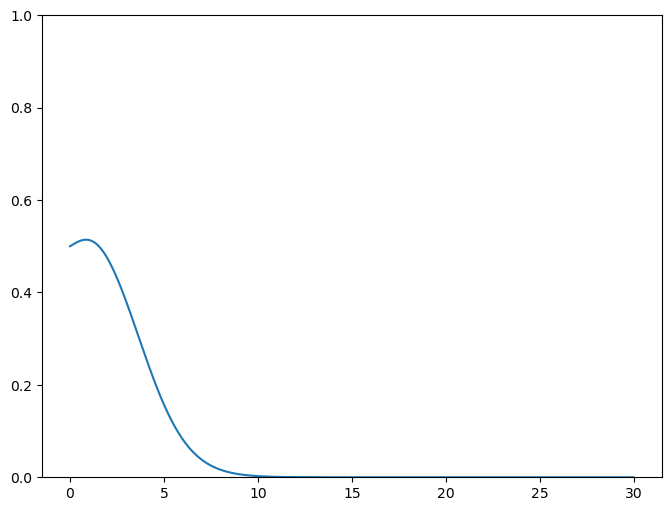

In [42]:
# Integrate

phi_p0 = 0.5
tmax = 30 * 60

L = 0

init = initial_sol.y[:,-1]
init[3] = phi_p0

sol = solve_ivp(odefun, [0, tmax], init, args=(lambda_c, L), method='BDF', t_eval=np.linspace(0, tmax, 10000), atol=1e-6, rtol=1e-9)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(sol.t / 60, sol.y[3,:], label=r'$\phi_p$')
ax.set_ylim([0, 1])